# Tutorial 4
## MA course in Artificial Intelligence 2022/2023

In [ ]:
!rm -rf AI2020MA
!git clone https://github.com/UmbertoJr/AI2022MA.git

In [15]:
# Imports
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IO_manager.io_tsp import TSP_Instance_Creator
from solvers.TSP_solver import Solver_TSP
from solvers.constructive_algorithms import Random_Initializer, Nearest_Neighbor
from solvers.constructive_algorithms import compute_length
from solvers.local_search import TwoOpt

# If you are not running from your local, add the prefix AI2021MA (comment the previous 3 lines and use instead the following 3 lines)
# from AI2022MA.IO_manager.io_tsp import TSP_Instance_Creator
# from AI2022MA.solvers.local_search import TwoOpt
# from AI2022MA.solvers.TSP_solver import Solver_TSP
# from AI2022MA.solvers.constructive_algorithms import Random_Initializer, Nearest_Neighbor
# from AI2022MA.solvers.constructive_algorithms import compute_length

# Iterated Local Search for the Travelling Salesman Problem

Let's read the standard TSP instance called 'd198.tsp'

name: d198
nPoints: 198
best_sol: 15780.0


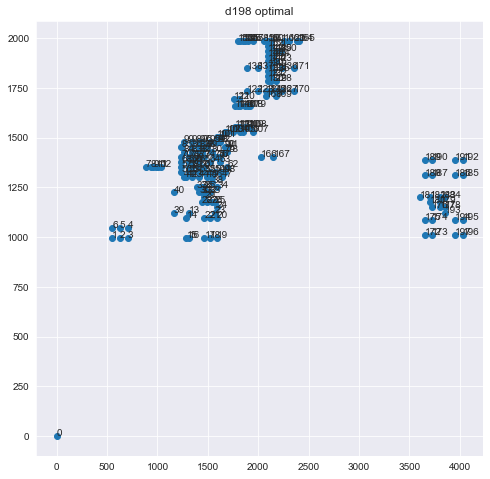

In [16]:
# Creating a TSP instance and printing the information about the instance and plotting the data.
ic = TSP_Instance_Creator("standard", 'd198.tsp')
ic.print_info()
ic.plot_data()

## Double Bridge

Here you need to implement your own Double Bridge permutation!

In [17]:
# A class that contains the methods to perform the double bridge perturbation and to compute
# the difference in cost between the edges that will be removed by the double bridge perturbation
# and the edges that will be added by the double bridge perturbation.
class DoubleBridge:

  @staticmethod
  def difference_cost(solution, a, b, c, d, matrix):
    """
    It computes the difference between the cost of the edges that will be added by the double bridge perturbation and
    the cost of the edges that will be removed by the double bridge perturbation.
    :param solution: The solution to be perturbed.
    :param a:        The first index of the first bridge.
    :param b:        The first city of the first bridge.
    :param c:        The index of the first city in the first bridge.
    :param d:        The number of cities in the TSP instance.
    :param matrix:   The distance matrix of the problem.
    :return:         The difference between the cost of the edges that will be added by the double bridge perturbation and
                     the cost of the edges that will be removed by the double bridge perturbation.
    """

    # Computing the cost of the edges that will be removed by the double bridge perturbation
    to_remove = matrix[solution[a - 1], solution[a]] + \
                matrix[solution[b - 1], solution[b]] + \
                matrix[solution[c - 1], solution[c]] + \
                matrix[solution[d - 1], solution[d]]

    # Computing the cost of the edges that will be added by the double bridge perturbation
    to_add = matrix[solution[a], solution[c - 1]] + \
             matrix[solution[b], solution[d - 1]] + \
             matrix[solution[c], solution[a - 1]] + \
             matrix[solution[d], solution[b - 1]]

    # Computing the difference between the cost of the edges that will be added and removed by the double bridge perturbation
    gain = to_add - to_remove

    return gain

  @staticmethod
  def perturb_solution(solution, actual_cost, matrix):
    """
    Given a solution, the cost of that solution, and the cost matrix, return a new solution that is a random perturbation of the original solution,
    by randomly selecting 4 points in the solution, and then swaps the order of the points between the 4 points.
    :param solution:    The current solution, that is a list of the indices of the cities in the order they are visited.
    :param actual_cost: The cost of the current solution.
    :param matrix:      The matrix of distances between cities.
    :return:            The new solution and the new cost.
    """
    # Randomly selecting 4 points in the solution, and then swapping the order of the points between the 4 points
    a, b, c, d = np.sort(np.random.choice(matrix.shape[0], size=4, replace=False))

    # Defining the segments of the solution ABCD
    B = solution[a:b]
    C = solution[b:c]
    D = solution[c:d]
    A = np.concatenate((solution[d:], solution[:a]))

    # Calculating the difference in cost between the current solution and the new solution
    gain = DoubleBridge.difference_cost(solution, a, b, c, d, matrix)

    # Defining the segments of the new solution ADCB
    new_solution = np.concatenate((A, D, C, B))

    # Adding the actual cost and the gain to get the new cost
    new_cost = actual_cost + gain

    return new_solution, new_cost

In [18]:
# Example of perturbation
case_solution = np.arange(12)
matrix = np.random.rand(12, 12)
cost = compute_length(case_solution, matrix)
print(case_solution, cost)

new_sol, new_length = DoubleBridge.perturb_solution(case_solution, cost, matrix)
print(new_sol, new_length)

[ 0  1  2  3  4  5  6  7  8  9 10 11] 6.010884233732607
[11  0  1  5  6  7  8  9 10  4  2  3] 6.822587187474588


Given ABCD = [ 0  1  2  3  4  5  6  7  8  9 10 11]
and   ADCB = [ 7  8  9 10 11  3  4  5  6  2  0  1]

Which are the vertices in the segments A, B, C and D here?
Which are the vertices a, b, c and d?

A is from 7 to 11
B is from 0 to 1
C is 2
D is from 3 to 6

a is 0
b is 2
c is 3
d is 7

## Iterated Local Search


Here you need to implement the three variants of the ILS we saw in class

To boost the time performances please use the cython class **two_opt_with_candidate**.


In [19]:
def my_local_search(s, c, d_matrix):
  """
  Given a solution, cost of the solution, and the distance matrix, return a new solution with a lower cost.
  :param s:        The solution to be improved (a list of integers, where each integer represents a city).
  :param c:        The cost of the solution.
  :param d_matrix: A matrix of distances between cities.
  :return:         The new solution and the new cost.
  """
  new_solution, new_cost = s, c

  for data in TwoOpt.local_search(s, c, d_matrix):
    new_solution, new_cost, number_calls_ls, ending_cond = data

  return new_solution, new_cost


# This class implements the Iterated Local Search (ILS) algorithm for the Better problem
class ILSBetter:
  @staticmethod
  def solve(s0, s0_cost, d_matrix):
    """
    Given a solution, the actual cost of that solution, and the matrix, return the new solution and the new actual cost.
    :param s0:       The solution to be improved (a list of the cities in the order they are visited).
    :param s0_cost:  The actual cost of the solution.
    :param d_matrix: The matrix of distances between cities, or A 2D array of the cost of each edge in the graph.
    """
    global cost_sol_better
    # Calling the local search function and passing the solution, actual cost and matrix as parameters
    s_star, s_star_cost = my_local_search(s0, s0_cost, d_matrix)
    calls = 1

    cost_sol_better.append(s_star_cost)

    while True:
      # implement perturbation
      s_prime, s_prime_cost = DoubleBridge.perturb_solution(s_star, s_star_cost, d_matrix)
      s_star_prime, s_star_prime_cost = my_local_search(s_prime, s_prime_cost, d_matrix)
      calls += 1

      # implement acceptance criterion
      if s_star_prime_cost < s_star_cost:
        s_star, s_star_cost = s_star_prime, s_star_prime_cost
        cost_sol_better.append(s_star_cost)

      yield s_star, s_star_cost, calls, False


# This class implements the Iterated Local Search (ILS) algorithm for the Random Walk (RW) problem
class ILSRw:
  @staticmethod
  def solve(s0, s0_cost, d_matrix):
    """
    Given a solution, the actual cost of that solution, and the matrix, return the new solution and the new actual cost.
    :param s0:       The solution to be improved (a list of the cities in the order they are visited).
    :param s0_cost:  The actual cost of the solution.
    :param d_matrix: The matrix of distances between cities, or A 2D array of the cost of each edge in the graph.
    """
    global cost_sol_RW

    # Using the local search algorithm to find a better solution
    s_star, s_star_cost = my_local_search(s0, s0_cost, d_matrix)
    calls = 1

    cost_sol_RW.append(s_star_cost)

    while True:
      # Implement perturbation
      s_prime, s_prime_cost = DoubleBridge.perturb_solution(s_star, s_star_cost, d_matrix)
      s_star_prime, s_star_prime_cost = my_local_search(s_prime, s_prime_cost, d_matrix)
      calls += 1

      # Implement acceptance criterion
      s_star, s_star_cost = s_star_prime, s_star_prime_cost
      cost_sol_RW.append(s_star_cost)

      yield s_star, s_star_cost, calls, False


# This class implements the Iterated Local Search (ILS) algorithm for the
# Large Step Markov Chain (LSMC) problem
class ILSLsmc:
  @staticmethod
  def solve(s0, s0_cost, d_matrix):
    """
    Given a solution, the actual cost of that solution, and the matrix,
    return the new solution and the new actual cost.
    It's a simulated annealing algorithm that uses a local search as a perturbation function.
    :param s0:       The solution to be perturbed (a list of the cities in the order they are visited).
    :param s0_cost:  The actual cost of the solution.
    :param d_matrix: The matrix of distances between cities, or a 2D array of the cost of each edge in the graph.
    """
    global cost_sol_better

    # Using the local search algorithm to find a better solution.
    s_star, s_star_cost = my_local_search(s0, s0_cost, d_matrix)
    calls = 1

    cost_sol_LSMC.append(s_star_cost)

    # Setting initial temperature such that acceptance probability is close to 1.
    temperature = np.abs(s_star_cost - s0_cost) * 100
    decrease = 0.95

    while True:
      # implement perturbation
      s_prime, s_prime_cost = DoubleBridge.perturb_solution(s_star, s_star_cost, d_matrix)
      s_star_prime, s_star_prime_cost = my_local_search(s_prime, s_prime_cost, d_matrix)
      calls += 1

      # implement acceptance criterion
      if ILSLsmc.acceptance_criterion(s_star_cost, s_star_prime_cost, temperature):
        s_star, s_star_cost = s_star_prime, s_star_prime_cost
        cost_sol_LSMC.append(s_star_cost)

      temperature *= decrease
      yield s_star, s_star_cost, calls, False

  @staticmethod
  def acceptance_criterion(s_star_cost, s_star_prime_cost, temperature):
    """
    If the new cost is better than the best cost, accept it, otherwise accept it
    with a probability that is proportional to the difference between the new cost and the best cost (the probability decreases as the temperature decreases).
    :param s_star_cost:       The cost of the best solution found so far.
    :param s_star_prime_cost: The cost of the new solution.
    :param temperature:       The current temperature of the system, a parameter that controls the probability of accepting a worse solution.
    :return:                  A boolean value.
    """

    if s_star_prime_cost < s_star_cost:
      return True
    else:
      alpha = np.random.rand(1)
      prob = np.exp((s_star_cost - s_star_prime_cost) / temperature)

      if alpha <= prob:
        return True
      else:
        return False


### Example of Table

Take care that you need to change the code in order to satisfy the requirements for the task! 

In [20]:
seeds = [0, 123, 333]
time_to_solve = 180  # in seconds

cost_sol_better = []
cost_sol_RW = []
cost_sol_LSMC = []

# Creating a dictionary with the names of the instances as keys and an empty dictionary as values.
names_instances = ["d198.tsp", "pr439.tsp", "u1060.tsp"]
samples = {name: {} for name in names_instances}
collectors = [cost_sol_better, cost_sol_RW, cost_sol_LSMC]

# Creating a list of initializers and a list of functions that will be used to initialize the weights.
initializers = ["random"]
init_functions = [Random_Initializer.random_method]

# Creating a list of strings and a list of functions.
improvements = ["ILS-better", "ILS-RW", "ILS-LSMC"]
improve_functions = [ILSBetter.solve, ILSRw.solve, ILSLsmc.solve]

results = []
index = []

# Running the solver for each instance, for each improvement method, for each initializer, for each seed.
for s_ in seeds:
  for i, init in enumerate(initializers):
    for j, improve in enumerate(improvements):
      solver = Solver_TSP((init, init_functions[i]), seed_=s_, stop_run_after=time_to_solve)
      solver.bind((improve, improve_functions[j]))
      for name in names_instances:
        instance = TSP_Instance_Creator("standard", name)
        solver(instance)
        index.append((name, instance.best_sol, solver.name_method, s_))
        results.append([solver.found_length, solver.gap, solver.time_to_solve, solver.ls_calls])
        samples[name][improve] = np.round(np.abs(np.array(collectors[j]) - ic.best_sol) / ic.best_sol * 100, 2)

index = pd.MultiIndex.from_tuples(index, names=['problem', 'optimal length', 'method', 'seed'])

pd.DataFrame(results, index=index, columns=["tour length", "gap", "time to solve", "calls local search"])

,,,,tour length,gap,time to solve,calls local search
problem,optimal length,method,seed,,,,
d198.tsp,15780.0,"initialized with random, improved with ILS-better",0,15877.0,0.61,180.107,732
pr439.tsp,107217.0,"initialized with random, improved with ILS-better",0,109727.0,2.34,181.685,126
u1060.tsp,224094.0,"initialized with random, improved with ILS-better",0,242455.0,8.19,184.136,18
d198.tsp,15780.0,"initialized with random, improved with ILS-RW",0,16611.0,5.27,7311.187,446
pr439.tsp,107217.0,"initialized with random, improved with ILS-RW",0,116122.0,8.31,2926.573,14
u1060.tsp,224094.0,"initialized with random, improved with ILS-RW",0,245748.0,9.66,185.038,18
d198.tsp,15780.0,"initialized with random, improved with ILS-LSMC",0,15847.0,0.42,180.031,729
pr439.tsp,107217.0,"initialized with random, improved with ILS-LSMC",0,117348.0,9.45,180.663,129
u1060.tsp,224094.0,"initialized with random, improved with ILS-LSMC",0,247365.0,10.38,183.882,18


#### Problem: d198.tsp

In [21]:
df1 = pd.DataFrame(results, index=index, columns=["tour length", "gap", "time to solve", "calls local search"]).filter(like = 'd198.tsp', axis=0)

df1.groupby(['method'])['tour length'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-LSMC",15839.0,15847.333333,8.504901
"initialized with random, improved with ILS-RW",16611.0,16786.000000,161.055891
"initialized with random, improved with ILS-better",15864.0,15909.333333,67.574650


In [22]:
df1.groupby(['method'])['gap'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-LSMC",0.37,0.423333,0.055076
"initialized with random, improved with ILS-RW",5.27,6.376667,1.020310
"initialized with random, improved with ILS-better",0.53,0.816667,0.429108


In [23]:
df1.groupby(['method'])['calls local search'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-LSMC",729,735.000000,7.937254
"initialized with random, improved with ILS-RW",446,631.666667,160.886088
"initialized with random, improved with ILS-better",732,739.000000,6.244998


The best result is found when initialized with random, and improved using ILS-LSMC as an acceptance criterion (Best: 15839; Avg: 15868; Std: 36.51) with respect to the tour length, the gap and number of calls.
However, Better achieve a better std with respect to the number of calls.

#### Problem: pr439.tsp

In [24]:
df2 = pd.DataFrame(results, index=index, columns=["tour length", "gap", "time to solve", "calls local search"]).filter(like = 'pr439.tsp', axis=0)

df2.groupby(['method'])['tour length'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-LSMC",113990.0,116953.000000,2786.576574
"initialized with random, improved with ILS-RW",115363.0,117222.666667,2591.659764
"initialized with random, improved with ILS-better",109727.0,110247.000000,472.795939


In [25]:
df2.groupby(['method'])['gap'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-LSMC",6.32,9.083333,2.599468
"initialized with random, improved with ILS-RW",7.60,9.333333,2.413593
"initialized with random, improved with ILS-better",2.34,2.823333,0.439811


In [26]:
df2.groupby(['method'])['calls local search'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-LSMC",129,129.333333,0.577350
"initialized with random, improved with ILS-RW",14,89.000000,64.953830
"initialized with random, improved with ILS-better",126,129.666667,4.725816


The best result is found when initialized with random, and improved using Better as an acceptance criterion (Best: 110031; Avg: 110348; Std: 310.26) with respect to the tour length, the gap and number of calls.
However, RW achieve a better std with respect to the number of calls.

#### Problem: u1060.tsp

In [27]:
df3 = pd.DataFrame(results, index=index, columns=["tour length", "gap", "time to solve", "calls local search"]).filter(like = 'u1060.tsp', axis=0)

df3.groupby(['method'])['tour length'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-LSMC",246718.0,247642.666667,1090.346887
"initialized with random, improved with ILS-RW",245274.0,246391.666667,1543.661340
"initialized with random, improved with ILS-better",242455.0,245372.000000,3360.075446


In [28]:
df3.groupby(['method'])['gap'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-LSMC",10.10,10.506667,0.482632
"initialized with random, improved with ILS-RW",9.45,9.950000,0.692170
"initialized with random, improved with ILS-better",8.19,9.493333,1.498077


In [29]:
df3.groupby(['method'])['calls local search'].agg(['min', 'mean', 'std'])

,min,mean,std
method,,,
"initialized with random, improved with ILS-LSMC",18,18.666667,0.577350
"initialized with random, improved with ILS-RW",17,18.333333,1.527525
"initialized with random, improved with ILS-better",18,18.666667,0.577350


The best result is found when initialized with random, and improved using Better as an acceptance criterion (Best: 241791; Avg: 245150; Std: 3657.04) with respect to the tour length,
even if LSMC has a better std.
The best gap is obtained using RW or LSMC, and the better number of calls is obtained with the LSMC on average.

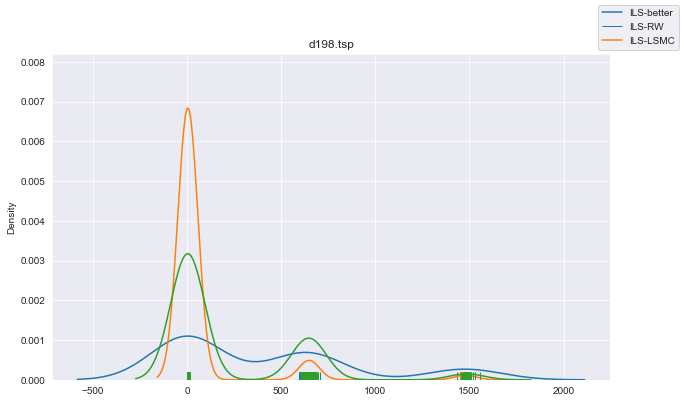

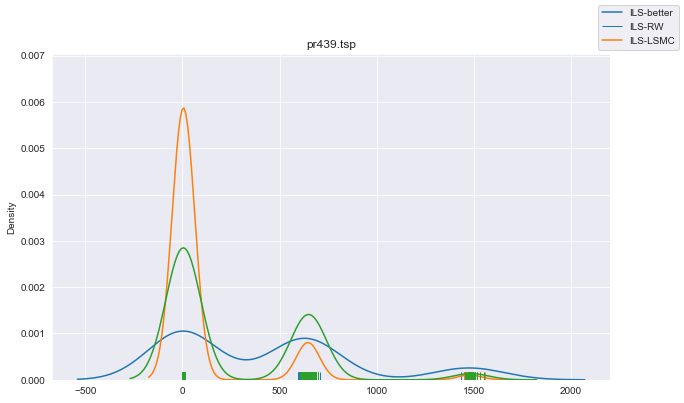

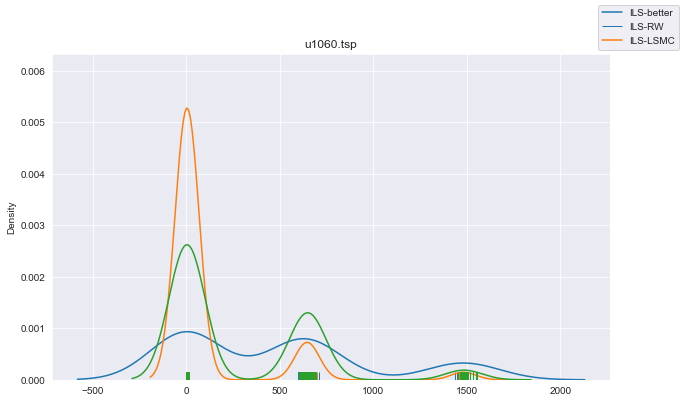

In [30]:
# Plotting the distribution of the improvements for each instance.
with warnings.catch_warnings():
  warnings.simplefilter("ignore")    
  for instance in names_instances:
    fig = plt.figure(figsize=(10,6))
    for j, improve in enumerate(improvements):
      sns.distplot(samples[instance][improve], rug=True, hist=False)
    
    fig.legend(labels=improvements)
    plt.title(instance)
    plt.show()

In [31]:
# Plotting the results of the different improvements for each instance.
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  for instance in names_instances:
    fig = plt.figure(figsize=(10,6))
    for j, improve in enumerate(improvements):
      data_for_seed_0_idx = results[j * 3][-1]
      print(max(samples[instance][improve][:data_for_seed_0_idx]))
      sns.lineplot(x=np.arange(data_for_seed_0_idx), y=samples[instance][improve][:data_for_seed_0_idx])

    fig.legend(labels=improvements)
    plt.title(instance)
    plt.show()

1530.75


ValueError: All arrays must be of the same length

<Figure size 720x432 with 0 Axes>